# 2.155/6 Challenge Problem 2
<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# TODO
- Feature engineering (proximity)
- Design new grids using GAs and rules of observations how advisors work
- Select better grids for diversity (not just off top minimum scores)

In [1]:
from utils_public import *
import numpy as np
import pandas as pd
import os, time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.base import clone

from autogluon.tabular import TabularPredictor

# This was needed to prevent several of the models from locking up when loading from autogluon saves
os.environ.update({"OMP_NUM_THREADS":"1","MKL_NUM_THREADS":"1","OPENBLAS_NUM_THREADS":"1"})

In [2]:
grids = load_grids()
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns = ["Wellness", "Tax", "Transportation", "Business"])

In [3]:
# TODO generate new grids with genetic algorithms?

## Fitting Regressors:

In [ ]:
from sklearn.metrics import r2_score
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor): 
    #Calculates 
    plt.figure(figsize=(6,3))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#BBBBBB") #train set in gray
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #test set in magenta
    plt.plot([0,1], [0,1], label="Target", linewidth=3, c="k") #target line in black

    #Set axis labels and title
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {advisor} Predictions")

    #Turn off top and right spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend() #Display legend
    plt.show() #Show plot

    #Calculate R2 score for train and test sets
    print(f"Advisor {advisor} Train Set R2 score: {r2_score(ratings_train, preds_train)}") 
    print(f"Advisor {advisor} Test Set R2 score: {r2_score(ratings_test, preds_test)}")

def append_district_counts(grids): #performs the feature engineering to add district counts
    grids_flat = grids.reshape(-1, 49) #first flatten the grids

    counts = [np.sum(grids_flat==0, axis=1),
              np.sum(grids_flat==1, axis=1),
              np.sum(grids_flat==2, axis=1),
              np.sum(grids_flat==3, axis=1),
              np.sum(grids_flat==4, axis=1)] #list of 5 length n_grids arrays containing counts of each district
    features = np.stack(counts).T #stack and transpose counts to get n_grids x 5 array
    out = np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids
    return out.astype(np.float32)  # ensure float32 dtype

def FE_split_train_eval(grids, FE_fn, advisor, ratings_subset): #feature engineering, split, train, evaluate
    # features -> DataFrame with numeric dtype
    grids_fa = pd.DataFrame(FE_fn(grids)).astype(np.float32)

    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_fa, ratings_subset) #split

    # ensure label arrays are float32
    ratings_train = np.array(ratings_train, dtype=np.float32)
    ratings_test  = np.array(ratings_test, dtype=np.float32)

    all_train = grids_train.copy().astype(np.float32)
    all_train["label"] = ratings_train

    predictor = TabularPredictor(label='label', problem_type='regression').fit(all_train, presets='medium', time_limit=30)
    predictor.delete_models(models_to_keep='best')

    # ensure inputs to predict have correct dtype
    preds_train = predictor.predict(grids_train.astype(np.float32))
    preds_test  = predictor.predict(grids_test.astype(np.float32))

    # convert predictions to float32 numpy for downstream numeric ops
    preds_train = np.array(preds_train, dtype=np.float32)
    preds_test  = np.array(preds_test, dtype=np.float32)

    plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor) #plot and calculate R2
    return predictor

def merge_predictions(grids, ratings, FE_fn, predictor): #Combine predictions and real ratings
    full_dataset_FA = pd.DataFrame(FE_fn(grids)).astype(np.float32) #feature engineering on full dataset
    predictions = predictor.predict(full_dataset_FA) #predict on full dataset

    # ensure predictions and ratings are numeric float32 numpy arrays
    predictions = np.array(predictions, dtype=np.float32)
    ratings_arr = np.array(ratings, dtype=np.float32)

    mask = ~np.isnan(ratings_arr) # boolean mask of rated entries
    if mask.any():
        predictions[mask] = ratings_arr[mask] #replace the predictions with the actual ratings where available
    return predictions

def fit_plot_predict(grids, ratings, FE_fn, advisor):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset rated by advisor 0
    predictor = FE_split_train_eval(grids_subset, FE_fn, advisor, ratings_subset) #feature engineering, split, train, evaluate
    predictions = merge_predictions(grids, ratings[:,advisor], FE_fn, predictor) #merge predictions with actual ratings
    return predictions

def advisor_train(grids, ratings, advisor):
    fit_plot_predict(grids, ratings, FE_fns[advisor], advisor)


def advisor_predict(grids, ratings, advisor):
    models = ["ag-20251021_010555",
              "ag-20251020_233146",
              "ag-20251020_235104",
              "ag-20251020_235823",]
    
    predictor = TabularPredictor.load("AutogluonModels/"+models[advisor])
    return merge_predictions(grids, ratings[:,advisor], FE_fns[advisor], predictor) #merge predictions with actual ratings

#TODO more feature engineering for advisor 0 and 2
FE_fns = [append_district_counts,
          append_district_counts,
          append_district_counts,
          append_district_counts]

# advisor_train(grids, ratings, 0)
# advisor_predict(grids[0:2000], ratings[0:2000], 1)

all_predictions = []
for i in range(0,4):
    print(f"Predicting Advisor {i}...")
    advisor_predictions = advisor_predict(grids[0:200], ratings[0:200], i)
    all_predictions.append(advisor_predictions)

Predicting Advisor 0...
Predicting Advisor 1...


/var/folders/zp/gdjwrfzs1h51y4wq1cnh46s40000gn/T/ipykernel_77068/3126437540.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.99533068 0.86936937 0.59309309 0.42242242]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  predictions[mask] = ratings[mask] #replace the predictions with the actual ratings where available


Predicting Advisor 2...


/var/folders/zp/gdjwrfzs1h51y4wq1cnh46s40000gn/T/ipykernel_77068/3126437540.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71671672 0.35035035]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  predictions[mask] = ratings[mask] #replace the predictions with the actual ratings where available


Predicting Advisor 3...


/var/folders/zp/gdjwrfzs1h51y4wq1cnh46s40000gn/T/ipykernel_77068/3126437540.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.20520521 0.34284284 0.54554555]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  predictions[mask] = ratings[mask] #replace the predictions with the actual ratings where available


Notes about models
- Advisor 0 - OSR2 = 0.6116
- Advisor 1 - OSR2 = 0.9249
- Advisor 2 - OSR2 = 0.4382
- Advisor 3 - OSR2 = 0.9748

## Selecting Best Grids:

Number of valid grids (as predicted): 0
Not enough valid grids found


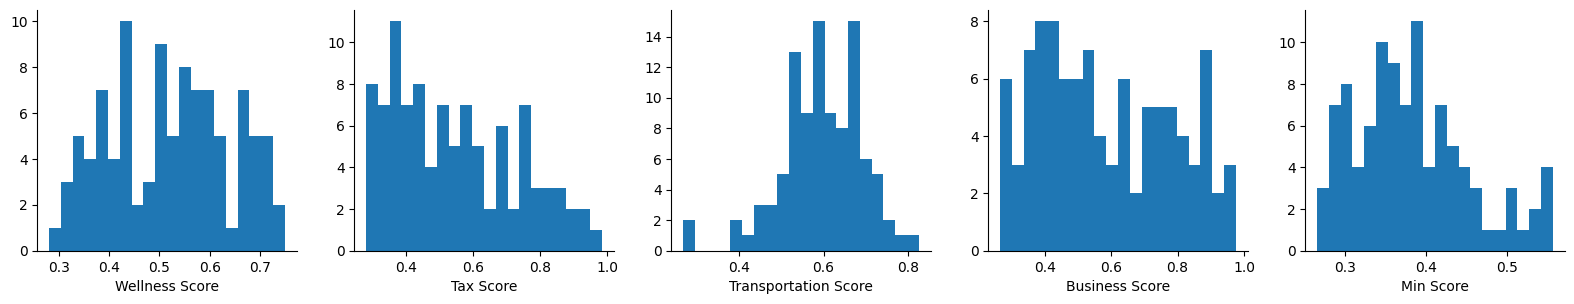

<Figure size 640x480 with 0 Axes>

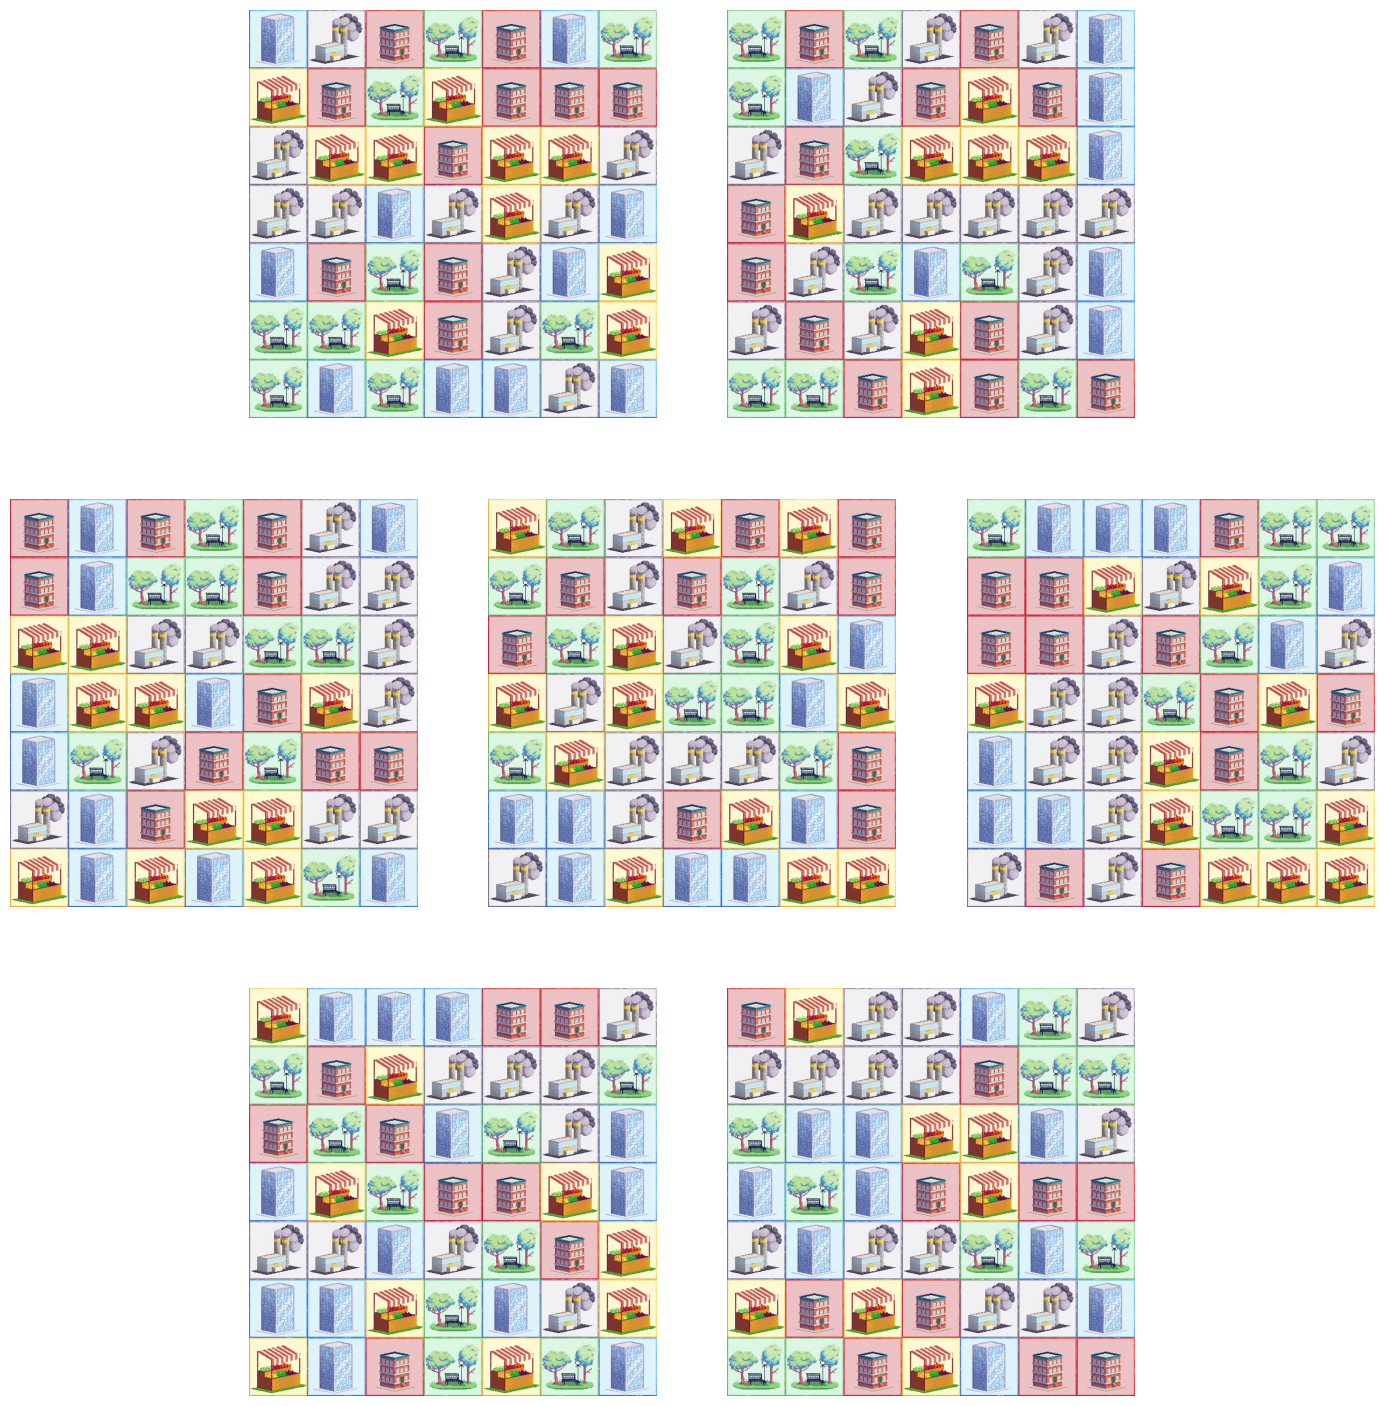

In [5]:
# TODO pick new grids if these are invalid, find a better way to pick grids
final_prediction_array = np.stack(all_predictions).T #stack the predictions
min_predictions = np.min(final_prediction_array, axis=1) #minimum advisor score (as predicted)
valid_grids = np.sum(min_predictions>0.75) #number of valid grids (as predicted)
top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)
top_100_grids = grids[top_100_indices] #get the top 100 grids

print(f"Number of valid grids (as predicted): {valid_grids}")
if valid_grids >= 100:
    score = diversity_score(top_100_grids)
    print(f"Current diversity score: {score:.4f}")

    best_submission = np.load("submission.npy")
    loaded_score = diversity_score(best_submission)
    if score > loaded_score:
        final_submission = grids[top_100_indices].astype(int)
        # id = np.random.randint(1e8, 1e9-1)
        # np.save(f"{id}.npy", final_submission) # uncomment this for real submission
        np.save(f"submission.npy", final_submission) 
        print(f"Score improved! Previous best: {loaded_score:.4f}")
        print("Submission saved")
    elif score <= loaded_score:
        print(f"No improvement. Previous best: {loaded_score:.4f}")
else:
    print("Not enough valid grids found")

plot_ratings_histogram(final_prediction_array[top_100_indices], withmin=True) #plot histograms of top 100 designs
plot_n_grids(top_100_grids[-7:])


In [6]:
## Autogluon Model leaderboard
# model_root = "AutogluonModels"
# model_dirs = sorted([d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))])
# for d in model_dirs:
#     path = os.path.join(model_root, d)
#     print("\n" + "="*80)
#     print(f"Leaderboard for {d} ({path})")
#     print("="*80)
#     predictor = TabularPredictor.load(path)
#     predictor.fit_summary(show_plot=False)